# YOLO11 객체 검출 및 라벨링 튜토리얼

이 노트북은 YOLO11을 사용하여 이미지에서 객체를 검출하고 다양한 도형으로 라벨링하는 방법을 단계별로 설명합니다.

## 목차
1. 환경 설정 및 라이브러리 설치
2. YOLO11 모델 로딩
3. 이미지에서 객체 검출
4. 다양한 도형으로 라벨링
5. 실전 예제

## 1. 환경 설정 및 라이브러리 설치

먼저 필요한 패키지를 설치합니다.

In [1]:
# 필요한 패키지 설치
!pip install ultralytics>=8.3.0
!pip install opencv-python>=4.8.0
!pip install matplotlib>=3.6.0
!pip install Pillow>=10.0.0
!pip install numpy>=1.24.0

## 2. 필요한 라이브러리 임포트

In [1]:
import cv2
import numpy as np
from ultralytics import YOLO
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle, Polygon
import matplotlib.patches as patches
from pathlib import Path
import random
import urllib.request
import os
from IPython.display import Image, display

# matplotlib 한글 폰트 설정 (선택사항)
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

print("모든 라이브러리가 성공적으로 임포트되었습니다!")

모든 라이브러리가 성공적으로 임포트되었습니다!


## 3. YOLODetector 클래스 정의

객체 검출과 라벨링을 위한 클래스를 정의합니다.

In [2]:
class YOLODetector:
    def __init__(self, model_path='yolo11n.pt'):
        """
        YOLO11 객체 검출기 초기화

        Args:
            model_path: YOLO 모델 경로 (기본값: yolo11n.pt)
        """
        self.model = YOLO(model_path)
        self.colors = {}
        print(f"모델 로드 완료: {model_path}")

    def get_random_color(self, class_id):
        """각 클래스에 대해 랜덤 색상 생성"""
        if class_id not in self.colors:
            self.colors[class_id] = (random.random(), random.random(), random.random())
        return self.colors[class_id]

    def detect_and_label(self, image_path, output_path=None, shape_type='auto', show_plot=True):
        """
        이미지에서 객체 검출 및 라벨링

        Args:
            image_path: 입력 이미지 경로
            output_path: 출력 이미지 경로
            shape_type: 표시할 도형 타입 ('rectangle', 'circle', 'polygon', 'auto')
            show_plot: 결과를 화면에 표시할지 여부
        """
        if not os.path.exists(image_path):
            print(f"이미지 파일을 찾을 수 없습니다: {image_path}")
            return None

        # 이미지 읽기
        image = cv2.imread(image_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # 객체 검출 수행
        print("객체 검출 중...")
        results = self.model(image_path)

        # matplotlib 설정
        fig, ax = plt.subplots(1, 1, figsize=(12, 8))
        ax.imshow(image_rgb)
        ax.axis('off')

        detected_objects = []

        # 검출된 객체들 처리
        for idx, result in enumerate(results):
            boxes = result.boxes
            if boxes is not None:
                for i, box in enumerate(boxes):
                    # 바운딩 박스 좌표
                    x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()

                    # 클래스 정보
                    cls = int(box.cls[0])
                    conf = float(box.conf[0])
                    label = f"{result.names[cls]} {conf:.2f}"

                    detected_objects.append({
                        'class': result.names[cls],
                        'confidence': conf,
                        'bbox': [x1, y1, x2, y2]
                    })

                    # 색상 선택
                    color = self.get_random_color(cls)

                    # shape_type이 'auto'인 경우 인덱스에 따라 도형 선택
                    if shape_type == 'auto':
                        shape_idx = i % 3
                        current_shape = ['rectangle', 'circle', 'polygon'][shape_idx]
                    else:
                        current_shape = shape_type

                    # 도형 그리기
                    if current_shape == 'rectangle':
                        rect = Rectangle((x1, y1), x2-x1, y2-y1,
                                       linewidth=2, edgecolor=color,
                                       facecolor='none', alpha=0.8)
                        ax.add_patch(rect)

                    elif current_shape == 'circle':
                        center_x = (x1 + x2) / 2
                        center_y = (y1 + y2) / 2
                        radius = min(x2-x1, y2-y1) / 2
                        circle = Circle((center_x, center_y), radius,
                                      linewidth=2, edgecolor=color,
                                      facecolor='none', alpha=0.8)
                        ax.add_patch(circle)

                    elif current_shape == 'polygon':
                        width = x2 - x1
                        height = y2 - y1
                        offset_x = width * 0.2
                        offset_y = height * 0.2

                        points = [
                            [x1 + offset_x, y1],
                            [x2 - offset_x, y1],
                            [x2, y1 + offset_y],
                            [x2, y2 - offset_y],
                            [x2 - offset_x, y2],
                            [x1 + offset_x, y2],
                            [x1, y2 - offset_y],
                            [x1, y1 + offset_y]
                        ]
                        polygon = Polygon(points, closed=True,
                                        linewidth=2, edgecolor=color,
                                        facecolor='none', alpha=0.8)
                        ax.add_patch(polygon)

                    # 라벨 텍스트 추가
                    ax.text(x1, y1-5, label, fontsize=10, color='white',
                           bbox=dict(boxstyle="round,pad=0.3",
                                   facecolor=color, alpha=0.7))

        # 결과 저장
        if output_path:
            plt.savefig(output_path, bbox_inches='tight', dpi=150, pad_inches=0.1)
            print(f"라벨링된 이미지가 저장되었습니다: {output_path}")

        if show_plot:
            plt.show()
        else:
            plt.close()

        print(f"\n검출된 객체 수: {len(detected_objects)}")
        for obj in detected_objects:
            print(f"  - {obj['class']}: {obj['confidence']:.2%} 신뢰도")

        return detected_objects

print("YOLODetector 클래스가 정의되었습니다!")

YOLODetector 클래스가 정의되었습니다!


## 4. 샘플 이미지 다운로드

테스트를 위한 샘플 이미지를 다운로드합니다.

샘플 이미지 다운로드 중...
샘플 이미지 다운로드 완료: test_image.jpg


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48376 (\N{HANGUL SYLLABLE BON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48120 (\N{HANGUL SYLLABLE MI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


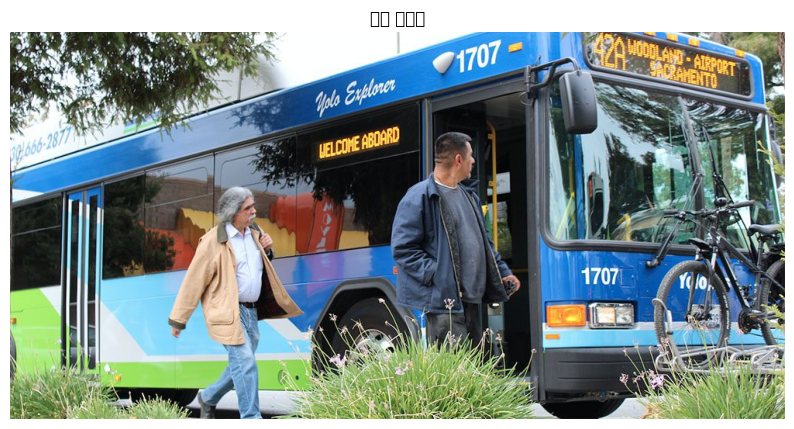

In [4]:
def download_sample_image(filename="test_image.jpg"):
    """테스트용 샘플 이미지 다운로드"""
    url = "https://www.transdev.com/wp-content/uploads/2020/03/yolo-hero-x.jpg"

    if not os.path.exists(filename):
        print("샘플 이미지 다운로드 중...")
        try:
            urllib.request.urlretrieve(url, filename)
            print(f"샘플 이미지 다운로드 완료: {filename}")
        except Exception as e:
            print(f"샘플 이미지 다운로드 실패: {e}")
            return None
    else:
        print(f"샘플 이미지가 이미 존재합니다: {filename}")

    # 이미지 표시
    img = cv2.imread(filename)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 6))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title("원본 이미지")
    plt.show()

    return filename

# 샘플 이미지 다운로드
sample_image = download_sample_image()

## 5. YOLO11 모델 초기화

YOLO11 모델을 로드합니다. 처음 실행 시 모델 파일이 자동으로 다운로드됩니다.

In [5]:
# YOLO 검출기 생성
detector = YOLODetector(model_path='yolo11n.pt')

# 사용 가능한 다른 모델들:
# - yolo11n.pt (Nano - 가장 빠름)
# - yolo11s.pt (Small)
# - yolo11m.pt (Medium)
# - yolo11l.pt (Large)
# - yolo11x.pt (Extra Large - 가장 정확함)

모델 로드 완료: yolo11n.pt


## 6. 다양한 도형으로 객체 검출 및 라벨링

### 6.1 자동 도형 선택 모드 (각 객체마다 다른 도형)

=== 자동 도형 선택 모드 ===
각 객체마다 다른 도형(사각형, 원, 다각형)이 자동으로 할당됩니다.

객체 검출 중...

image 1/1 /content/test_image.jpg: 320x640 2 persons, 1 bicycle, 2 buss, 1 handbag, 52.3ms
Speed: 6.4ms preprocess, 52.3ms inference, 4.3ms postprocess per image at shape (1, 3, 320, 640)
라벨링된 이미지가 저장되었습니다: output_auto.jpg


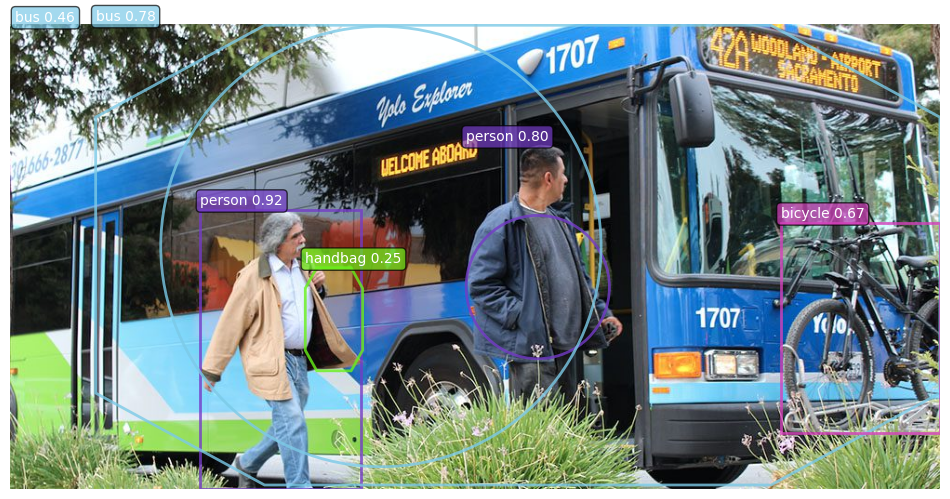


검출된 객체 수: 6
  - person: 91.96% 신뢰도
  - person: 80.29% 신뢰도
  - bus: 78.31% 신뢰도
  - bicycle: 66.86% 신뢰도
  - bus: 46.10% 신뢰도
  - handbag: 25.04% 신뢰도


In [6]:
if sample_image:
    print("=== 자동 도형 선택 모드 ===")
    print("각 객체마다 다른 도형(사각형, 원, 다각형)이 자동으로 할당됩니다.\n")

    detected = detector.detect_and_label(
        image_path=sample_image,
        output_path="output_auto.jpg",
        shape_type='auto'
    )

### 6.2 사각형 모드

=== 사각형 모드 ===
모든 객체를 사각형으로 표시합니다.

객체 검출 중...

image 1/1 /content/test_image.jpg: 320x640 2 persons, 1 bicycle, 2 buss, 1 handbag, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 3.3ms postprocess per image at shape (1, 3, 320, 640)
라벨링된 이미지가 저장되었습니다: output_rectangle.jpg


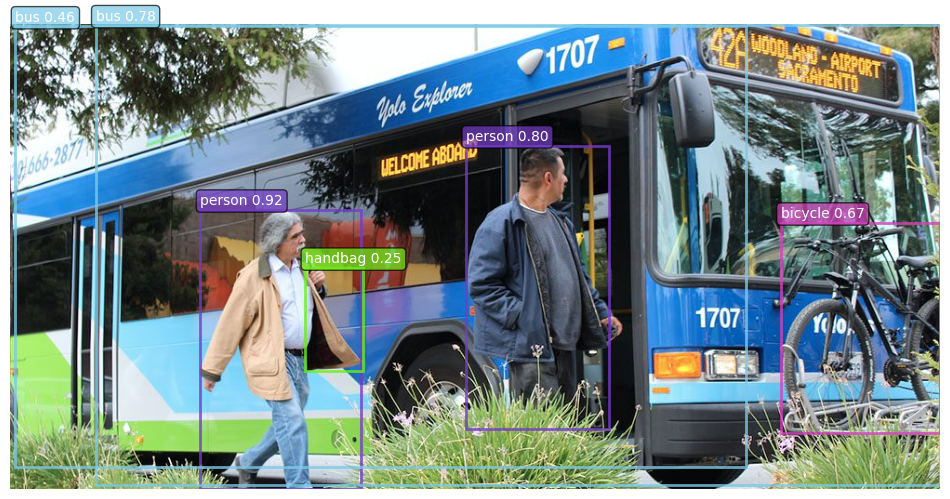


검출된 객체 수: 6
  - person: 91.96% 신뢰도
  - person: 80.29% 신뢰도
  - bus: 78.31% 신뢰도
  - bicycle: 66.86% 신뢰도
  - bus: 46.10% 신뢰도
  - handbag: 25.04% 신뢰도


In [7]:
if sample_image:
    print("=== 사각형 모드 ===")
    print("모든 객체를 사각형으로 표시합니다.\n")

    detected = detector.detect_and_label(
        image_path=sample_image,
        output_path="output_rectangle.jpg",
        shape_type='rectangle'
    )

### 6.3 원 모드

=== 원 모드 ===
모든 객체를 원으로 표시합니다.

객체 검출 중...

image 1/1 /content/test_image.jpg: 320x640 2 persons, 1 bicycle, 2 buss, 1 handbag, 8.3ms
Speed: 1.7ms preprocess, 8.3ms inference, 3.2ms postprocess per image at shape (1, 3, 320, 640)
라벨링된 이미지가 저장되었습니다: output_circle.jpg


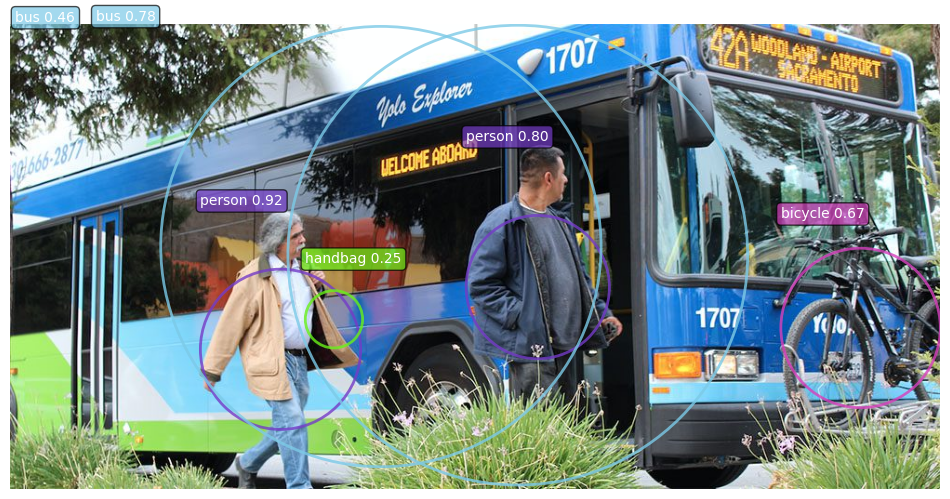


검출된 객체 수: 6
  - person: 91.96% 신뢰도
  - person: 80.29% 신뢰도
  - bus: 78.31% 신뢰도
  - bicycle: 66.86% 신뢰도
  - bus: 46.10% 신뢰도
  - handbag: 25.04% 신뢰도


In [8]:
if sample_image:
    print("=== 원 모드 ===")
    print("모든 객체를 원으로 표시합니다.\n")

    detected = detector.detect_and_label(
        image_path=sample_image,
        output_path="output_circle.jpg",
        shape_type='circle'
    )

### 6.4 다각형 모드

=== 다각형 모드 ===
모든 객체를 8각형으로 표시합니다.

객체 검출 중...

image 1/1 /content/test_image.jpg: 320x640 2 persons, 1 bicycle, 2 buss, 1 handbag, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 3.3ms postprocess per image at shape (1, 3, 320, 640)
라벨링된 이미지가 저장되었습니다: output_polygon.jpg


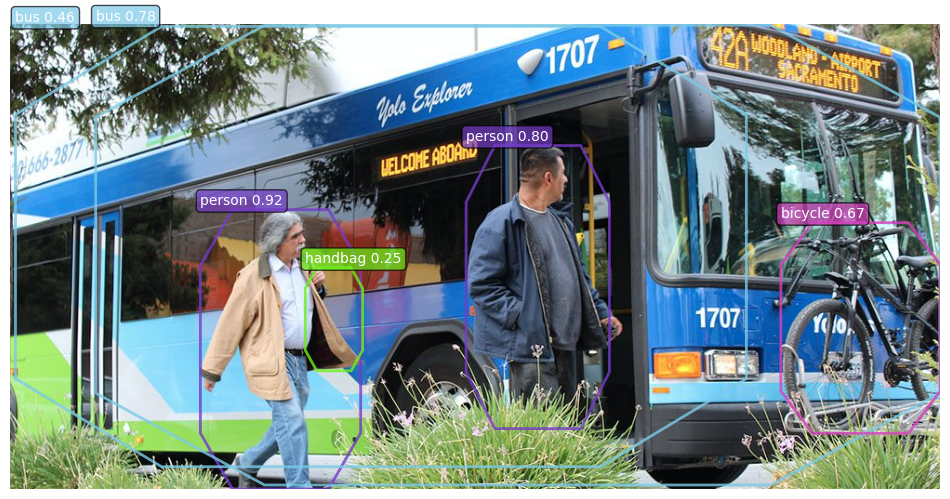


검출된 객체 수: 6
  - person: 91.96% 신뢰도
  - person: 80.29% 신뢰도
  - bus: 78.31% 신뢰도
  - bicycle: 66.86% 신뢰도
  - bus: 46.10% 신뢰도
  - handbag: 25.04% 신뢰도


In [9]:
if sample_image:
    print("=== 다각형 모드 ===")
    print("모든 객체를 8각형으로 표시합니다.\n")

    detected = detector.detect_and_label(
        image_path=sample_image,
        output_path="output_polygon.jpg",
        shape_type='polygon'
    )

## 7. 사용자 이미지로 테스트

자신의 이미지 파일로 테스트해보세요!

In [ ]:
# 자신의 이미지 파일 경로를 입력하세요
# 예: "my_image.jpg" 또는 "C:/Users/username/Pictures/photo.jpg"
your_image_path = "your_image.jpg"  # 이 부분을 수정하세요!

if os.path.exists(your_image_path):
    print(f"이미지 처리 중: {your_image_path}")

    # 원본 이미지 표시
    img = cv2.imread(your_image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 6))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title("원본 이미지")
    plt.show()

    # 객체 검출 및 라벨링
    detected = detector.detect_and_label(
        image_path=your_image_path,
        output_path="your_output.jpg",
        shape_type='auto'  # 'rectangle', 'circle', 'polygon', 'auto' 중 선택
    )
else:
    print(f"파일을 찾을 수 없습니다: {your_image_path}")
    print("위의 your_image_path 변수를 실제 이미지 파일 경로로 수정해주세요.")

## 8. 검출 결과 분석

검출된 객체들의 통계를 분석해봅시다.

샘플 이미지 검출 결과 분석
객체 검출 중...

image 1/1 /content/test_image.jpg: 320x640 2 persons, 1 bicycle, 2 buss, 1 handbag, 8.5ms
Speed: 1.7ms preprocess, 8.5ms inference, 4.2ms postprocess per image at shape (1, 3, 320, 640)

검출된 객체 수: 6
  - person: 91.96% 신뢰도
  - person: 80.29% 신뢰도
  - bus: 78.31% 신뢰도
  - bicycle: 66.86% 신뢰도
  - bus: 46.10% 신뢰도
  - handbag: 25.04% 신뢰도

=== 검출 결과 통계 ===
총 검출된 객체 수: 6
검출된 클래스 종류: 4

클래스별 검출 수:
  - person: 2개 (평균 신뢰도: 86.13%)
  - bus: 2개 (평균 신뢰도: 62.20%)
  - bicycle: 1개 (평균 신뢰도: 66.86%)
  - handbag: 1개 (평균 신뢰도: 25.04%)


/tmp/ipython-input-3025797591.py:57: UserWarning: Glyph 44061 (\N{HANGUL SYLLABLE GAEG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3025797591.py:57: UserWarning: Glyph 52404 (\N{HANGUL SYLLABLE CE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3025797591.py:57: UserWarning: Glyph 53364 (\N{HANGUL SYLLABLE KEUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3025797591.py:57: UserWarning: Glyph 47000 (\N{HANGUL SYLLABLE RAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3025797591.py:57: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3025797591.py:57: UserWarning: Glyph 44160 (\N{HANGUL SYLLABLE GEOM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3025797591.py:57: UserWarning: Glyph 52636 (\N{HANGUL SYLLABLE CUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout

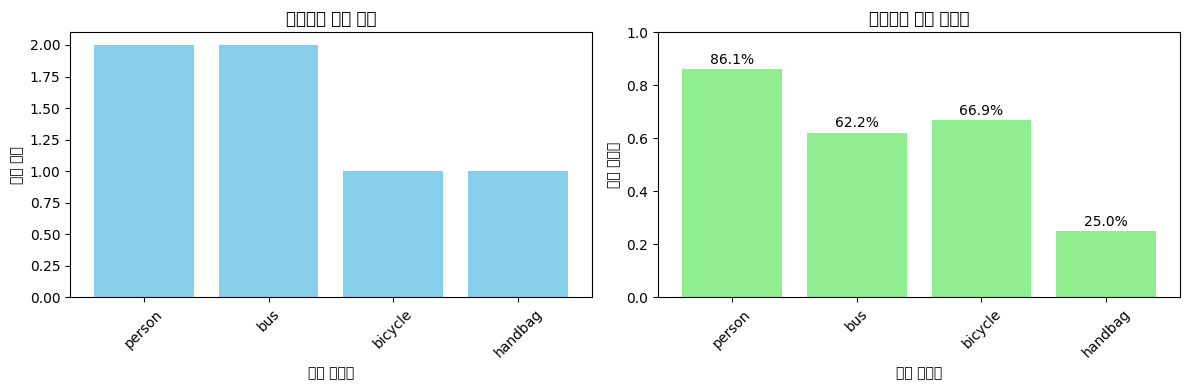

In [10]:
def analyze_detection_results(detected_objects):
    """검출 결과 분석 및 시각화"""
    if not detected_objects:
        print("검출된 객체가 없습니다.")
        return

    # 클래스별 통계
    class_counts = {}
    confidence_scores = {}

    for obj in detected_objects:
        cls = obj['class']
        conf = obj['confidence']

        if cls not in class_counts:
            class_counts[cls] = 0
            confidence_scores[cls] = []

        class_counts[cls] += 1
        confidence_scores[cls].append(conf)

    # 결과 출력
    print("\n=== 검출 결과 통계 ===")
    print(f"총 검출된 객체 수: {len(detected_objects)}")
    print(f"검출된 클래스 종류: {len(class_counts)}")
    print("\n클래스별 검출 수:")
    for cls, count in class_counts.items():
        avg_conf = np.mean(confidence_scores[cls])
        print(f"  - {cls}: {count}개 (평균 신뢰도: {avg_conf:.2%})")

    # 시각화
    if len(class_counts) > 0:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

        # 클래스별 개수 막대 그래프
        classes = list(class_counts.keys())
        counts = list(class_counts.values())
        ax1.bar(classes, counts, color='skyblue')
        ax1.set_xlabel('객체 클래스')
        ax1.set_ylabel('검출 개수')
        ax1.set_title('클래스별 검출 개수')
        ax1.tick_params(axis='x', rotation=45)

        # 평균 신뢰도 막대 그래프
        avg_confs = [np.mean(confidence_scores[cls]) for cls in classes]
        ax2.bar(classes, avg_confs, color='lightgreen')
        ax2.set_xlabel('객체 클래스')
        ax2.set_ylabel('평균 신뢰도')
        ax2.set_title('클래스별 평균 신뢰도')
        ax2.set_ylim([0, 1])
        ax2.tick_params(axis='x', rotation=45)

        # 신뢰도를 퍼센트로 표시
        for i, (cls, conf) in enumerate(zip(classes, avg_confs)):
            ax2.text(i, conf + 0.02, f'{conf:.1%}', ha='center')

        plt.tight_layout()
        plt.show()

# 샘플 이미지의 검출 결과 분석
if sample_image:
    print("샘플 이미지 검출 결과 분석")
    detected = detector.detect_and_label(
        image_path=sample_image,
        shape_type='auto',
        show_plot=False
    )
    analyze_detection_results(detected)

## 9. 배치 처리 예제

여러 이미지를 한 번에 처리하는 예제입니다.

In [ ]:
def batch_process_images(image_list, detector, shape_type='auto'):
    """여러 이미지를 배치로 처리"""
    results = []

    for img_path in image_list:
        if os.path.exists(img_path):
            print(f"\n처리 중: {img_path}")
            output_name = f"batch_{Path(img_path).stem}_output.jpg"

            detected = detector.detect_and_label(
                image_path=img_path,
                output_path=output_name,
                shape_type=shape_type,
                show_plot=False
            )

            results.append({
                'image': img_path,
                'output': output_name,
                'objects': detected
            })
        else:
            print(f"파일을 찾을 수 없음: {img_path}")

    return results

# 배치 처리 예제 (실제 이미지 경로로 수정하세요)
image_list = [
    "test_image.jpg",  # 샘플 이미지
    # "image1.jpg",    # 추가 이미지 경로
    # "image2.jpg",    # 추가 이미지 경로
]

# 배치 처리 실행
batch_results = batch_process_images(image_list, detector, shape_type='auto')

# 결과 요약
print("\n=== 배치 처리 결과 요약 ===")
for result in batch_results:
    print(f"\n이미지: {result['image']}")
    print(f"출력 파일: {result['output']}")
    print(f"검출된 객체 수: {len(result['objects']) if result['objects'] else 0}")

## 10. 실시간 검출 시뮬레이션 (웹캠이나 비디오)

비디오 파일이나 웹캠으로부터 실시간 객체 검출을 수행하는 예제입니다.

In [ ]:
def process_video_frame(frame, detector, shape_type='rectangle'):
    """
    비디오 프레임 처리 함수
    실제 비디오 처리를 위한 템플릿 코드
    """
    # 프레임을 임시 파일로 저장
    temp_path = "temp_frame.jpg"
    cv2.imwrite(temp_path, frame)

    # 객체 검출
    detected = detector.detect_and_label(
        image_path=temp_path,
        shape_type=shape_type,
        show_plot=False
    )

    # 임시 파일 삭제
    os.remove(temp_path)

    return detected

# 비디오 처리 예제 코드 (실제 사용시 주석 해제)
"""
# 웹캠 사용 예제
cap = cv2.VideoCapture(0)  # 0은 기본 웹캠

# 비디오 파일 사용 예제
# cap = cv2.VideoCapture('video.mp4')

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # 프레임 처리
    detected = process_video_frame(frame, detector)

    # 결과 표시 (OpenCV 창)
    cv2.imshow('YOLO Detection', frame)

    # 'q' 키를 누르면 종료
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
"""

print("비디오 처리 코드 템플릿이 준비되었습니다.")
print("실제 사용시 위의 주석을 해제하고 사용하세요.")

## 11. 커스텀 설정 및 고급 기능

YOLO 모델의 고급 설정을 조정하는 방법입니다.

In [ ]:
class AdvancedYOLODetector(YOLODetector):
    """고급 기능이 추가된 YOLO 검출기"""

    def detect_with_filter(self, image_path, confidence_threshold=0.5,
                          target_classes=None, shape_type='auto'):
        """
        필터링 기능이 추가된 객체 검출

        Args:
            confidence_threshold: 최소 신뢰도 임계값
            target_classes: 검출할 클래스 리스트 (None이면 모든 클래스)
        """
        # 기본 검출 수행
        results = self.model(image_path, conf=confidence_threshold)

        filtered_objects = []

        for result in results:
            if result.boxes is not None:
                for box in result.boxes:
                    cls = int(box.cls[0])
                    class_name = result.names[cls]
                    conf = float(box.conf[0])

                    # 클래스 필터링
                    if target_classes and class_name not in target_classes:
                        continue

                    filtered_objects.append({
                        'class': class_name,
                        'confidence': conf,
                        'bbox': box.xyxy[0].cpu().numpy().tolist()
                    })

        print(f"필터링된 객체 수: {len(filtered_objects)}")
        return filtered_objects

# 고급 검출기 생성
advanced_detector = AdvancedYOLODetector()

# 특정 클래스만 검출 (예: 사람, 자동차, 버스만)
if sample_image:
    print("=== 필터링된 검출 (사람, 자동차, 버스만) ===")
    filtered_results = advanced_detector.detect_with_filter(
        image_path=sample_image,
        confidence_threshold=0.5,
        target_classes=['person', 'car', 'bus']
    )

    for obj in filtered_results:
        print(f"  - {obj['class']}: {obj['confidence']:.2%}")

## 12. 검출 성능 측정

모델의 검출 속도와 성능을 측정합니다.

In [ ]:
import time

def measure_performance(detector, image_path, num_runs=5):
    """검출 성능 측정"""
    times = []

    print(f"성능 측정 중... ({num_runs}회 실행)")

    for i in range(num_runs):
        start_time = time.time()

        # 검출 수행
        results = detector.model(image_path)

        end_time = time.time()
        elapsed_time = end_time - start_time
        times.append(elapsed_time)

        print(f"  실행 {i+1}: {elapsed_time:.3f}초")

    # 통계 계산
    avg_time = np.mean(times)
    std_time = np.std(times)
    fps = 1 / avg_time

    print(f"\n=== 성능 측정 결과 ===")
    print(f"평균 처리 시간: {avg_time:.3f}초 (±{std_time:.3f})")
    print(f"FPS: {fps:.1f}")
    print(f"최소 시간: {min(times):.3f}초")
    print(f"최대 시간: {max(times):.3f}초")

    return times

# 성능 측정
if sample_image:
    times = measure_performance(detector, sample_image, num_runs=5)

    # 시각화
    plt.figure(figsize=(8, 4))
    plt.plot(range(1, len(times)+1), times, 'bo-')
    plt.axhline(y=np.mean(times), color='r', linestyle='--', label=f'평균: {np.mean(times):.3f}초')
    plt.xlabel('실행 횟수')
    plt.ylabel('처리 시간 (초)')
    plt.title('YOLO11 검출 성능')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

## 13. 모델 정보 및 설정

현재 사용 중인 YOLO 모델의 정보를 확인합니다.

In [ ]:
def print_model_info(detector):
    """모델 정보 출력"""
    model = detector.model

    print("=== YOLO 모델 정보 ===")
    print(f"모델 타입: {model.__class__.__name__}")

    # 클래스 이름 출력
    if hasattr(model, 'names'):
        print(f"\n검출 가능한 클래스 수: {len(model.names)}")
        print("\n검출 가능한 클래스 목록:")
        for idx, name in model.names.items():
            print(f"  {idx:3d}: {name}")
            if idx >= 10:  # 처음 10개만 표시
                print(f"  ... 그리고 {len(model.names) - 11}개 더")
                break

# 모델 정보 출력
print_model_info(detector)

## 14. 결론 및 다음 단계

축하합니다! YOLO11을 사용한 객체 검출 및 라벨링의 기본을 마스터하셨습니다.

### 학습한 내용:
- ✅ YOLO11 모델 로딩 및 초기화
- ✅ 이미지에서 객체 검출
- ✅ 다양한 도형으로 객체 라벨링 (사각형, 원, 다각형)
- ✅ 검출 결과 분석 및 시각화
- ✅ 배치 처리
- ✅ 성능 측정

### 다음 단계:
1. **커스텀 데이터셋으로 모델 학습**: 자신만의 객체를 검출하도록 모델 훈련
2. **실시간 비디오 처리**: 웹캠이나 비디오 파일에서 실시간 검출
3. **모델 최적화**: 더 빠른 추론을 위한 모델 경량화
4. **웹 애플리케이션 구축**: Flask/FastAPI를 사용한 웹 서비스 구현

### 유용한 리소스:
- [Ultralytics YOLO 공식 문서](https://docs.ultralytics.com/)
- [YOLO11 GitHub 저장소](https://github.com/ultralytics/ultralytics)
- [컴퓨터 비전 튜토리얼](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html)

## 부록: 자주 묻는 질문 (FAQ)

### Q1: GPU를 사용하려면 어떻게 해야 하나요?
CUDA가 설치되어 있다면 자동으로 GPU를 사용합니다. 확인 방법:
```python
import torch
print(f"CUDA 사용 가능: {torch.cuda.is_available()}")
```

### Q2: 다른 모델 크기를 사용하려면?
```python
detector = YOLODetector(model_path='yolo11x.pt')  # 더 정확한 모델
```

### Q3: 특정 객체만 검출하려면?
위의 AdvancedYOLODetector 클래스의 detect_with_filter 메서드를 참조하세요.

### Q4: 검출 속도를 높이려면?
- 더 작은 모델 사용 (yolo11n.pt)
- 이미지 크기 줄이기
- GPU 사용
- 배치 처리 활용

In [ ]:
# 노트북 완료 메시지
print("🎉 YOLO11 튜토리얼을 완료했습니다!")
print("질문이 있으시면 GitHub Issues에 남겨주세요.")
print("Happy Coding! 🚀")